In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

# regular expressions
import re

%matplotlib inline

In [4]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

In [7]:
# Credit to Sina for her Titanic Best Working Classifier!

# create family size variable
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# If family size == 1, a person is traveling by his/herself and for that is counted as 'Alone'
for dataset in full_data:
    dataset['IsAlone'] = 0 # default to 0, meaning not alone
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1 # Check for no companions
    
# If no information about embarkment, assume they joined in S
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Use median imputation method for Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Impute missing Age data
for dataset in full_data:
    avg_age = dataset['Age'].mean()
    std_age = dataset['Age'].std()
    null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(avg_age - std_age, avg_age + std_age, size=null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# define regular expression function to extract a person's title
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # if a title was found:
    if title_search:
        return title_search.group(1)
    return ""

# Create a new Column for Title
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(extract_title)
    
# since there are quite a lot of rare titles (e.g. 'Countess'), we'll group them as 'rare'
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') # Also replace french titles with common english abr.
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Now we have to transform everything categorical into numerical values by mapping
for dataset in full_data:
    
    # Transform gender into 0 for female and 1 for male
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Transform Age to a few categories
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age' ] = 1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age' ] = 2
    dataset.loc[ (dataset['Age'] > 38) & (dataset['Age'] <= 64), 'Age' ] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age' ] = 4
    
    # Map titles to values
    title_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_map)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Map City of Embarkment to value
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

C:\Users\Jan Pascal Kunkler\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,2,0,"[0, 7.91]","(16, 32]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,2,0,"(31, 512.329]","(32, 48]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,1,1,"(7.91, 14.454]","(16, 32]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,44,2,0,"(31, 512.329]","(32, 48]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,24,1,1,"(7.91, 14.454]","(32, 48]",1


In [9]:
# Now we'll drop any variables we don't need for our predictions 
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

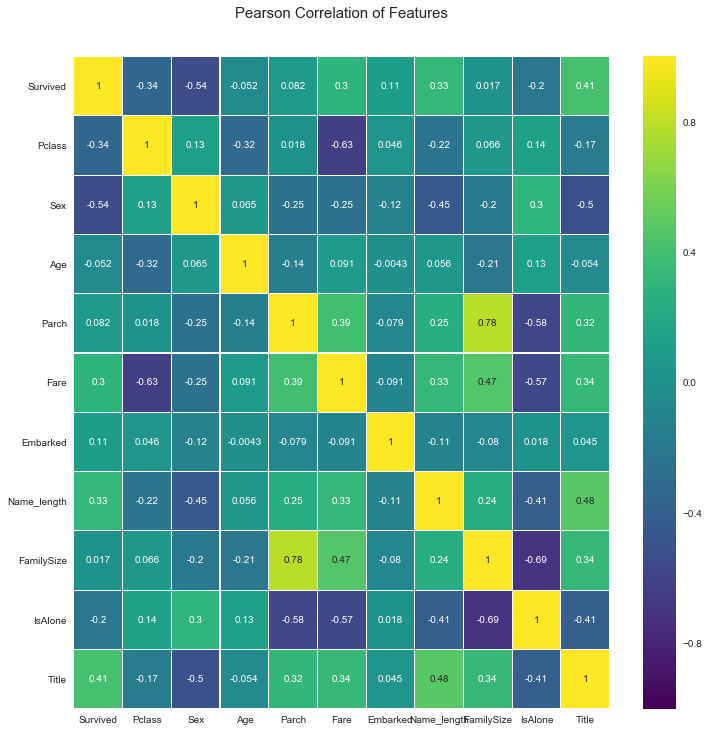

In [10]:
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), annot=True, cmap='viridis', linecolor='white', linewidths=0.1)

C:\Users\Jan Pascal Kunkler\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Jan Pascal Kunkler\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Jan Pascal Kunkler\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


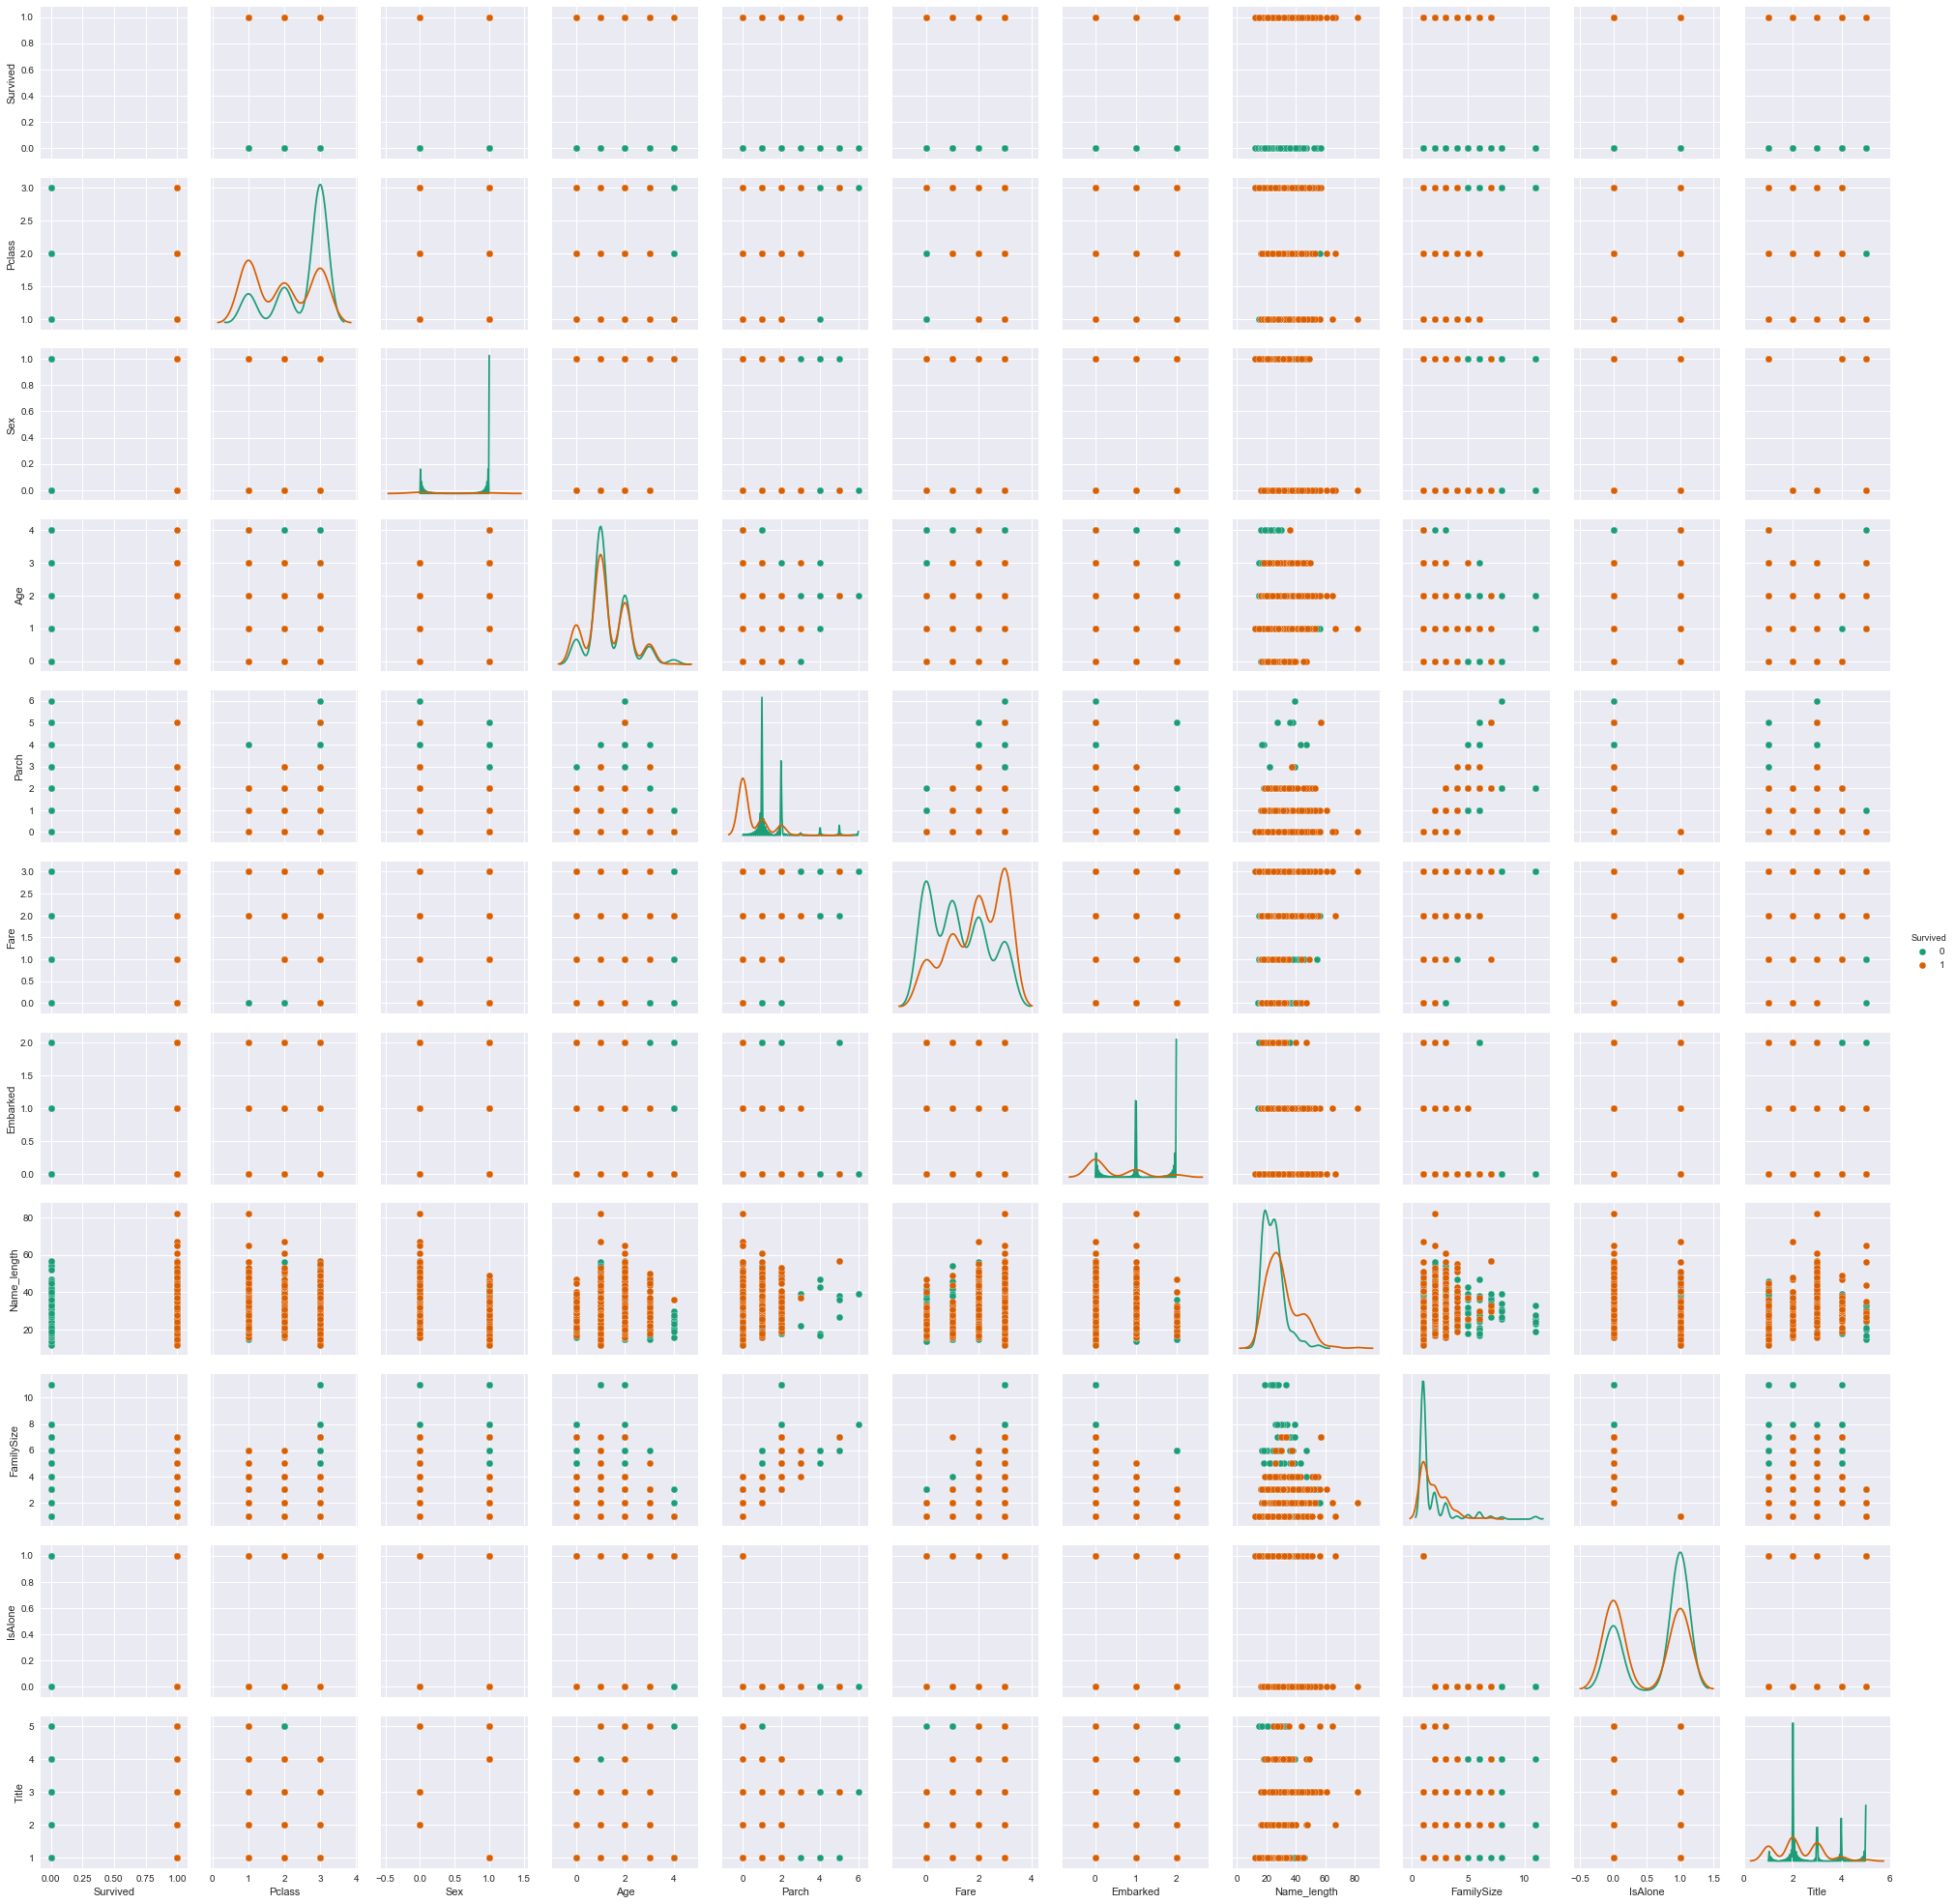

In [11]:
sns.pairplot(train, hue='Survived', diag_kind='kde', palette='Dark2')

In [12]:
# Import everything needed from SKLearn

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
#from sklearn.model_selection import KFold
from sklearn.cross_validation import KFold;

C:\Users\Jan Pascal Kunkler\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
#kf = KFold(NFOLDS, random_state=SEED)
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return(self.clf.fit(x,y).feature_importances_)

In [14]:
# Out-Of-Fold Predictions
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [15]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [16]:
# Create objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [17]:
# Split data into train and test sets
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [18]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

C:\Users\Jan Pascal Kunkler\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:303: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [19]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)

C:\Users\Jan Pascal Kunkler\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:303: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


In [20]:
# Create dataframe from above feature importances
cols = train.columns.values
feature_dataframe = pd.DataFrame({'features': cols,
              'Random Forest feature importances': rf_features,
              'Extra Trees feature importances': et_features,
              'AdaBoost feature importances': ada_features,
              'Gradient Boost feature importances': gb_features
             })

In [21]:
feature_dataframe.head()

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features
0,0.030,0.166667,0.086350,0.147213,Pclass
1,0.012,0.373305,0.034364,0.200342,Sex
2,0.022,0.031990,0.107092,0.032268,Age
3,0.068,0.018068,0.028683,0.022034,Parch
4,0.042,0.067242,0.099660,0.081039,Fare


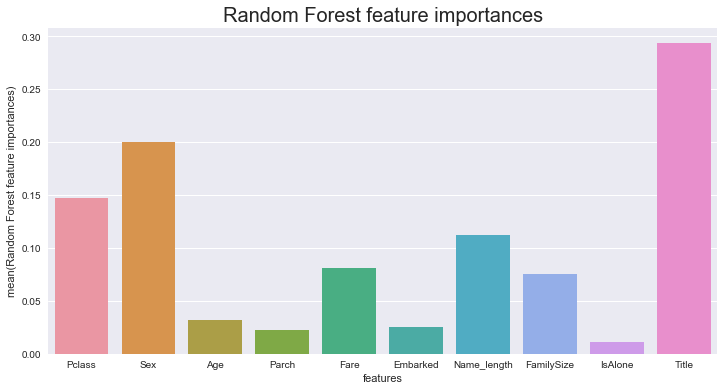

In [22]:
plt.figure(figsize=(12,6))
plt.title('Random Forest feature importances', size=20)
sns.barplot(x='features', y='Random Forest feature importances', data=feature_dataframe)

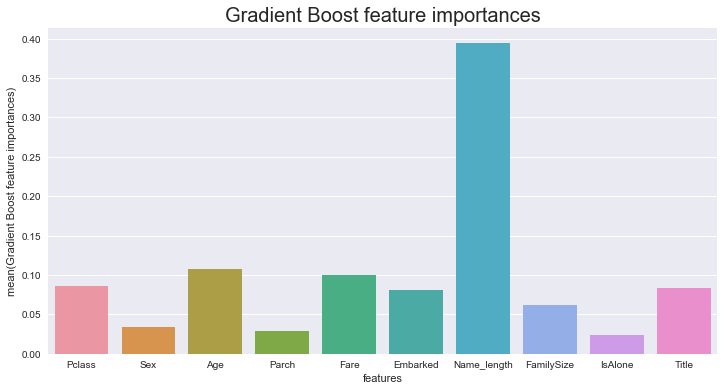

In [23]:
plt.figure(figsize=(12,6))
plt.title('Gradient Boost feature importances', size=20)
sns.barplot(x='features', y='Gradient Boost feature importances', data=feature_dataframe)

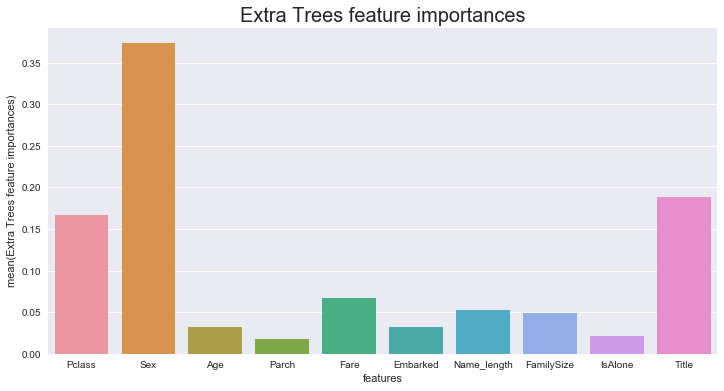

In [24]:
plt.figure(figsize=(12,6))
plt.title('Extra Trees feature importances', size=20)
sns.barplot(x='features', y='Extra Trees feature importances', data=feature_dataframe)

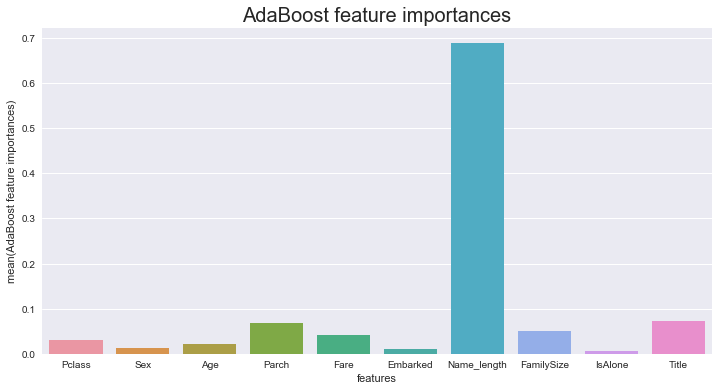

In [25]:
plt.figure(figsize=(12,6))
plt.title('AdaBoost feature importances', size=20)
sns.barplot(x='features', y='AdaBoost feature importances', data=feature_dataframe)

In [26]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.030,0.166667,0.086350,0.147213,Pclass,0.107558
1,0.012,0.373305,0.034364,0.200342,Sex,0.155003
2,0.022,0.031990,0.107092,0.032268,Age,0.048338
3,0.068,0.018068,0.028683,0.022034,Parch,0.034196
4,0.042,0.067242,0.099660,0.081039,Fare,0.072485
5,0.010,0.031657,0.080910,0.025176,Embarked,0.036936
6,0.688,0.052560,0.394192,0.111892,Name_length,0.311661
7,0.050,0.049375,0.061400,0.075346,FamilySize,0.059030
8,0.006,0.020875,0.023528,0.011039,IsAlone,0.015360
9,0.072,0.188260,0.083820,0.293650,Title,0.159433


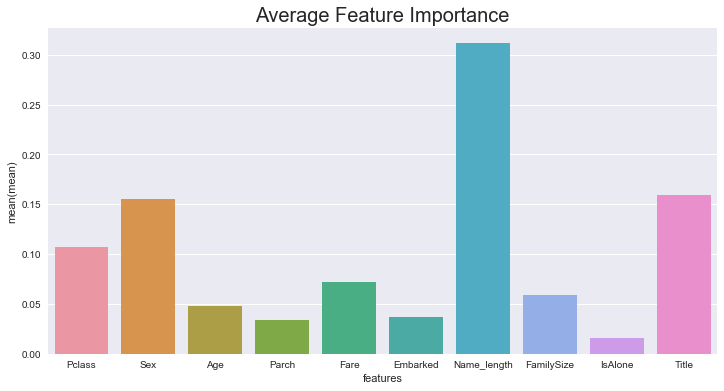

In [27]:
plt.figure(figsize=(12,6))
plt.title('Average Feature Importance', size=20)
sns.barplot(x='features', y='mean', data=feature_dataframe)

In [28]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


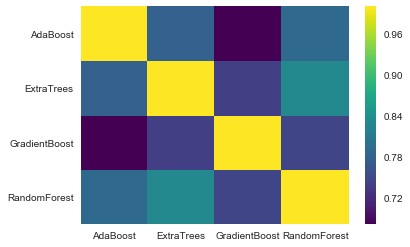

In [29]:
sns.heatmap(base_predictions_train.astype(float).corr(), cmap='viridis')

In [30]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [36]:
# Create and fit the Gradient Boosting Model
gbm = xgb.XGBClassifier(
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

gbm.fit(x_train, y_train)

print('Accuracy:',gbm.score(x_train, y_train))
# Predict survival on test data
predictions = gbm.predict(x_test)

Accuracy: 0.87317620651


In [37]:
# Generate Submission File 
Submission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
Submission.to_csv("Submission.csv", index=False)